In [1]:
import torch
from torch import optim, nn, utils, Tensor
import lightning as L

import numpy as np
import matplotlib.pyplot as plt

from Network import Generator, Discriminator
from Signal_Generator import *
from Signal_Analyzer import *

from getdist import plots, MCSamples
import getdist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = []

for i in range(100):
    SG = Signal_Generator(num_sources=1, noise_amplitude=1)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = torch.tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = torch.tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_loader = utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

num_latent_variables = 10
learning_rate = 0.0001

In [3]:
class GAN():
    def __init__(self, dataset, num_latent_variables, lr):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)
        self.criterion = nn.BCELoss()

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def adversarial_loss(self, output_d, y):
        return self.criterion(output_d, y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = self.adversarial_loss(fake_output, torch.ones_like(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        real_loss = self.adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = self.adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2
        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        return d_loss.item()

In [4]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

d_loss_list = []
# Train the GAN
for i in range(200):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        d_loss_list.append(d_loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

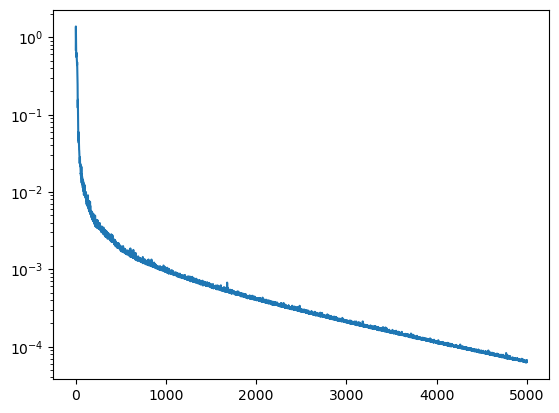

In [5]:
plt.plot(d_loss_list)
plt.yscale('log')

In [6]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

g_loss_list = []
# Train the GAN
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        g_loss = gan.train_generator(signal_tensor, z)
        g_loss_list.append(g_loss)
    #print(f"Epoch {i}, Discriminator loss: {g_loss}")

c:\Users\Administrater\.conda\envs\MasLISA\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


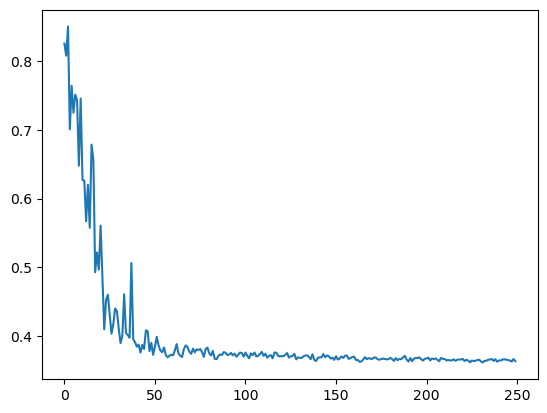

In [7]:
plt.plot(g_loss_list)
#plt.yscale('log')

In [8]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)
g_loss_list = []
d_loss_list = []

num_epochs = 50
num_discriminator = 30
num_generator = 3

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)

        for _ in range(num_discriminator):
            g_loss = gan.train_generator(signal_tensor, z)
            g_loss_list.append(g_loss)

        for _ in range(num_generator):
            d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
            d_loss_list.append(d_loss)
    print(f"Epoch {epoch}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")

Epoch 0, Generator loss: 0.6998239755630493, Discriminator loss: 0.6936750411987305
Epoch 1, Generator loss: 0.6961122155189514, Discriminator loss: 0.6936846375465393
Epoch 2, Generator loss: 0.6962975263595581, Discriminator loss: 0.6954742074012756
Epoch 3, Generator loss: 0.6944022178649902, Discriminator loss: 0.6958833932876587
Epoch 4, Generator loss: 0.7004164457321167, Discriminator loss: 0.6934463977813721
Epoch 5, Generator loss: 0.6937589049339294, Discriminator loss: 0.6967434883117676
Epoch 6, Generator loss: 0.6725988984107971, Discriminator loss: 0.6944931745529175
Epoch 7, Generator loss: 0.6981933116912842, Discriminator loss: 0.6949320435523987
Epoch 8, Generator loss: 0.6994270086288452, Discriminator loss: 0.6925175189971924
Epoch 9, Generator loss: 0.6860907077789307, Discriminator loss: 0.6945135593414307
Epoch 10, Generator loss: 0.6897656321525574, Discriminator loss: 0.6926423907279968
Epoch 11, Generator loss: 0.6855422854423523, Discriminator loss: 0.6918225

In [9]:
generator = gan.generator
generator.eval()

for i in range(10):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    print(params)
    print(generated_params)

[10.576665883025239, 0.4339453737704822, 1.7872232078309034]
[9.675797   1.0940704  0.33296424]
[11.506132277275103, 0.2366253053624801, 4.810427732480229]
[8.047246   0.01569215 2.1991453 ]
[9.887334860753036, 0.2777366361661808, 2.3868423960212604]
[8.253569   1.040501   0.19447011]
[9.344866567321825, 0.3365868761572566, 0.45736658270271036]
[8.947733  0.2643875 2.0702004]
[10.823471318215582, 0.22136753631421818, 5.923322539257601]
[ 9.295949   1.1340992 -0.5489952]
[8.606961674593162, 0.344667421803161, 0.18797471398490145]
[ 9.110537   1.3261274 -1.4530027]
[13.733404445809946, 0.38409405596654966, 2.70449810686008]
[ 9.340921    1.352782   -0.24312216]
[8.926817372575226, 0.2566201492031491, 4.741252006006175]
[ 9.3071451e+00  8.6084741e-01 -2.9906295e-03]
[9.841979805818267, 0.2777622511092142, 1.493528002729195]
[8.916316   0.16961625 1.8325945 ]
[10.994581618539645, 0.23293774650721272, 2.870386996115332]
[ 8.2367      0.75746703 -1.2598944 ]


In [10]:
class WGAN():
    def __init__(self, dataset, num_latent_variables, lr, weight_clip):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = -torch.mean(fake_output)

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)


        return d_loss.item()

In [11]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.01)

d_loss_list = []
# Train the GAN
for i in range(200):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        d_loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        d_loss_list.append(d_loss)
    #print(f"Epoch {i}, Discriminator loss: {d_loss}")

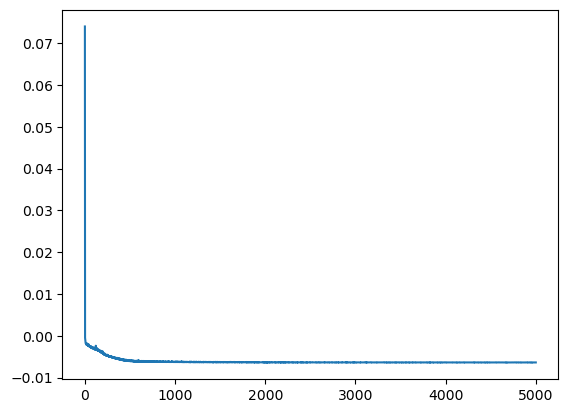

In [12]:
plt.plot(d_loss_list)

In [13]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.01)

g_loss_list = []
# Train the GAN
for i in range(20):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        g_loss = wgan.train_generator(signal_tensor, z)
        g_loss_list.append(g_loss)
    #print(f"Epoch {i}, Discriminator loss: {g_loss}")

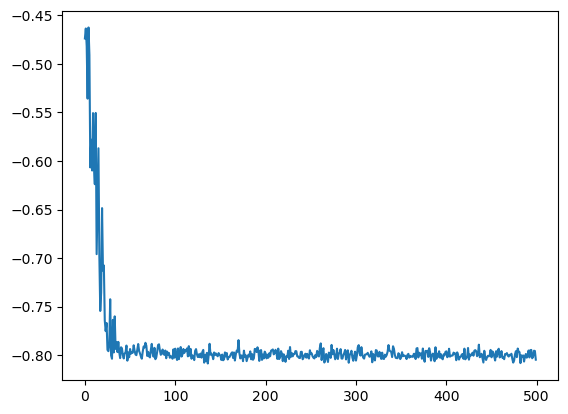

In [14]:
plt.plot(g_loss_list)

In [24]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.01)

g_loss_list = []
d_loss_list = []

num_epochs = 300
num_critic = 5
num_generator = 3

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        signal_tensor = signal_tensor.to(device)
        params_tensor = params_tensor.to(device)
        
        for _ in range(num_critic):
            d_loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        
        for _ in range(num_generator):
            g_loss = wgan.train_generator(signal_tensor, z)
        
        g_loss_list.append(g_loss)
        d_loss_list.append(d_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")

Epoch 1/300, Generator loss: -0.5031565427780151, Discriminator loss: -0.0002657175064086914
Epoch 2/300, Generator loss: -0.5039994120597839, Discriminator loss: -0.00018680095672607422
Epoch 3/300, Generator loss: -0.5046286582946777, Discriminator loss: -0.0003732442855834961
Epoch 4/300, Generator loss: -0.5048285722732544, Discriminator loss: -6.03795051574707e-05
Epoch 5/300, Generator loss: -0.5044200420379639, Discriminator loss: -0.001765608787536621
Epoch 6/300, Generator loss: -0.5037870407104492, Discriminator loss: -0.0017699003219604492
Epoch 7/300, Generator loss: -0.5036107301712036, Discriminator loss: -0.0014281272888183594
Epoch 8/300, Generator loss: -0.5043504238128662, Discriminator loss: -0.0003674030303955078
Epoch 9/300, Generator loss: -0.5041074156761169, Discriminator loss: -0.0004572868347167969
Epoch 10/300, Generator loss: -0.5042776465415955, Discriminator loss: -0.0006374120712280273
Epoch 11/300, Generator loss: -0.5034903883934021, Discriminator loss:

In [29]:
generator = wgan.generator
generator.eval()

params_list = []
generated_params_list = []

for i in range(100):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    params_list.append(params)
    generated_params_list.append(generated_params)

    print(params)
    print(generated_params)

[11.1868059909863, 0.23445426150613494, 1.7396045094831845]
[12.495869    0.58673835  6.1972957 ]
[8.502578029629708, 0.26691675606247767, 2.3571781156990834]
[11.266017   -0.93840843  4.326537  ]
[11.272493337539949, 0.30909903412091777, 3.351867927021753]
[10.059882   -0.03214751  4.951177  ]
[12.14425892914588, 0.35606264953145683, 5.868728385948838]
[12.052664   -0.74276257  4.7286234 ]
[8.78953058648679, 0.41307238218302444, 5.707169184235351]
[11.713707   -0.35648894  6.075892  ]
[6.34337103424817, 0.28369185737846936, 3.8296886180646674]
[9.797922  0.7326395 3.0798712]
[8.435077301058918, 0.36879699131646165, 1.6777388734515137]
[10.141347  -0.8319656  4.11776  ]
[13.909800798009528, 0.3249680550193782, 4.994957833330448]
[11.32742    1.2912107  4.500423 ]
[9.886040120692202, 0.303406854492148, 3.8279837719587966]
[10.437546    0.40122274  4.543719  ]
[9.585053347100022, 0.28953478098400703, 0.1430766635527336]
[10.632992    0.41632771  6.1319394 ]
[12.852587436757625, 0.3012486

Removed no burn in
Removed no burn in


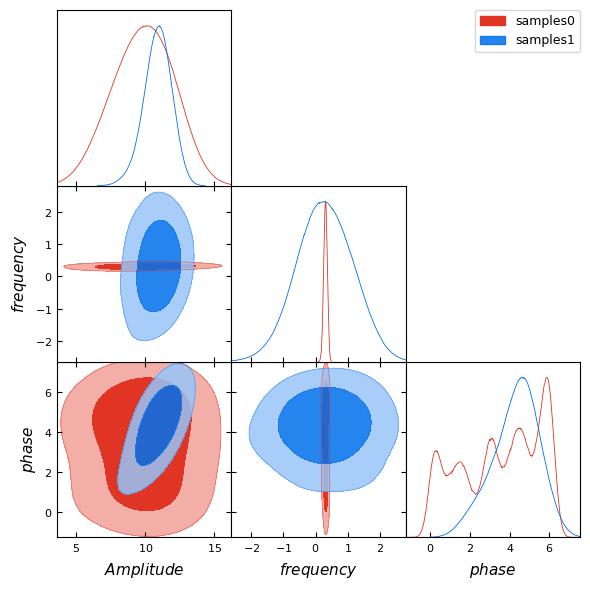

In [32]:
params_df = pd.DataFrame(params_list, columns=['Amplitude', 'Frequency', 'Phase'])
generated_params_df = pd.DataFrame(generated_params_list, columns=['Amplitude', 'Frequency', 'Phase'])

names = ["A","omega","theta"]
labels =  ["Amplitude","frequency","phase"]

params_samples = MCSamples(samples=params_df.values, names=names, labels=labels)
generated_params_samples = MCSamples(samples=generated_params_df.values, names=names, labels=labels)
#samples.setRanges([[-3,3],[-3,3]])
params_samples.updateSettings({'fine_bins_2D': 1048})
generated_params_samples.updateSettings({'fine_bins_2D': 1048})

In [ ]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([params_samples, generated_params_samples], filled=True)

#print(params_samples.getTable().tableTex())
#print(generated_params_samples.getTable().tableTex())

#g.export('300epochs.png')